In [16]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

In [17]:
!pip install ultralytics==8.3.19

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.19 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.4/107.7 GB disk)


## Install Roboflow Supervision

In [19]:
!pip install supervision[assets]==0.24.0
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.24.0


In [20]:
print(dir(sv))

['BackgroundOverlayAnnotator', 'BaseDataset', 'BlurAnnotator', 'BoundingBoxAnnotator', 'BoxAnnotator', 'BoxCornerAnnotator', 'ByteTrack', 'CSVSink', 'CircleAnnotator', 'ClassificationDataset', 'Classifications', 'Color', 'ColorAnnotator', 'ColorLookup', 'ColorPalette', 'ConfusionMatrix', 'CropAnnotator', 'DetectionDataset', 'Detections', 'DetectionsSmoother', 'DotAnnotator', 'EdgeAnnotator', 'EllipseAnnotator', 'FPSMonitor', 'HaloAnnotator', 'HeatMapAnnotator', 'IconAnnotator', 'ImageSink', 'InferenceSlicer', 'JSONSink', 'KeyPoints', 'LMM', 'LabelAnnotator', 'LineZone', 'LineZoneAnnotator', 'LineZoneAnnotatorMulticlass', 'MaskAnnotator', 'MeanAveragePrecision', 'OrientedBoxAnnotator', 'OverlapFilter', 'PercentageBarAnnotator', 'PixelateAnnotator', 'Point', 'PolygonAnnotator', 'PolygonZone', 'PolygonZoneAnnotator', 'Position', 'Rect', 'RichLabelAnnotator', 'RoundBoxAnnotator', 'TraceAnnotator', 'TriangleAnnotator', 'VertexAnnotator', 'VertexLabelAnnotator', 'VideoInfo', 'VideoSink', '__

## Download example video

In [21]:
from supervision.assets import download_assets, VideoAssets

# SOURCE_VIDEO_PATH = download_assets(VideoAssets.VEHICLES)
SOURCE_VIDEO_PATH= '/content/sample.mp4'

## Load pre-trained YOLOv8 model

In [22]:
from ultralytics import YOLO

model = YOLO("yolov8x.pt")

## Predict and annotate single frame

In [23]:
CLASS_NAMES_DICT = model.model.names

SELECTED_CLASS_NAMES = ['car', 'motorcycle', 'bus', 'truck']

# class ids matching the class names we have chosen
SELECTED_CLASS_IDS = [
    {value: key for key, value in CLASS_NAMES_DICT.items()}[class_name]
    for class_name
    in SELECTED_CLASS_NAMES
]

In [24]:
model.model.names

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [25]:
SELECTED_CLASS_IDS

[2, 3, 5, 7]

In [26]:
import numpy as np
import cv2


In [39]:
video = cv2.VideoCapture(SOURCE_VIDEO_PATH)

total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

target_frame_index = total_frames // 30

video.release() #frees memory

generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Convert generator to an iterator
iterator = iter(generator)

for _ in range(target_frame_index):
    next(iterator)  # Discard previous frames

target_frame = next(iterator)

# sv.plot_image(target_frame, (16, 16))
target_frame_index

42

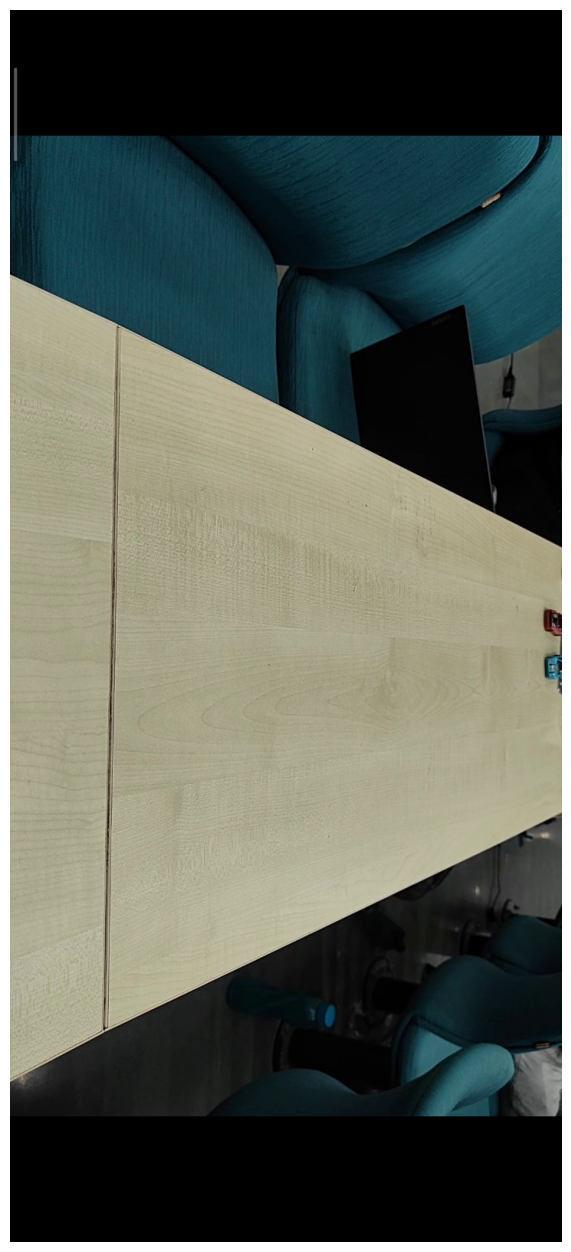

In [41]:
# model prediction on single frame and conversion to supervision Detections
results = model(target_frame, verbose=False)[0]

box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)

detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate and display frame
annotated_frame = target_frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

## Predict and annotate whole video

In [42]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=720, height=1608, fps=59, total_frames=1283)

In [45]:
# settings
LINE_START = sv.Point(0 + 50, 1500)
LINE_END = sv.Point(3840 - 50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/result.mp4"

In [ ]:
# create BYTETracker instance
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3)

byte_tracker.reset()

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator, LabelAnnotator, and TraceAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels)

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)